# Machine Learning Exercise 4 
## Task : Create An Email Spam Filter Using Naïve Bayes
### Step 1
Start By Importing The Required Libraries And Read The Dataset Into A DataFrame. Output The First 10 Rows Of The DataFrame To Get The General Feel Of How The Data Is Structured. 

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from math import log

dfEmail = pd.read_csv('Emails.csv', encoding='latin-1')
dfEmail.head(10)

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN
5,spam,FreeMsg Hey there darling it's been 3 week's n...,NaN,NaN,NaN
6,ham,Even my brother is not like to speak with me. ...,NaN,NaN,NaN
7,ham,As per your request 'Melle Melle (Oru Minnamin...,NaN,NaN,NaN
8,spam,WINNER!! As a valued network customer you have...,NaN,NaN,NaN
9,spam,Had your mobile 11 months or more? U R entitle...,NaN,NaN,NaN


### Step 2
Since We Are Only Interested In Words, Clean The Data So That All Punctuation And Numbers Are Removed. You Should Be Left With A Dataset Containing Only Alpha Characters (Including Spaces). You Should Also Ensure All The Words Are Lowercase. Store The Cleaned Data Into A New DataFrame. 

In [11]:
cleanData = pd.DataFrame(columns = ['Category', 'Message'])
cleanData['Category'] = dfEmail['v1']
cleanData['Message'] = dfEmail['v2'].str.replace('[^a-zA-Z ]', '', regex=True)
cleanData['Message'] = cleanData['Message'].str.lower()
cleanData.head(10)

,Category,Message
0,ham,go until jurong point crazy available only in ...
1,ham,ok lar joking wif u oni
2,spam,free entry in a wkly comp to win fa cup final...
3,ham,u dun say so early hor u c already then say
4,ham,nah i dont think he goes to usf he lives aroun...
5,spam,freemsg hey there darling its been weeks now ...
6,ham,even my brother is not like to speak with me t...
7,ham,as per your request melle melle oru minnaminun...
8,spam,winner as a valued network customer you have b...
9,spam,had your mobile months or more u r entitled t...


### Step 3
Split The Data Into Two Random Samples, One For Training The Model And The Other For Testing The Model. Create DataFrames Named trainData And testData Where trainData Contains 75% Of The Data And testData Contains The Remaining 25%.

In [10]:
trainData = cleanData.sample(frac = 0.75)
testData = cleanData.drop(trainData.index)
trainData = trainData.reset_index(drop=True)
testData = testData.reset_index(drop=True)

### Step 4
Create A New DataFrame Called wordFrequency That Contains Each Word And The Number Of Times It Appears In A Spam And Not In A Spam Message. You Should Use The trainData And Not The testData.

In [12]:
wordFrequency = pd.DataFrame(columns=['Word', 'Spam', '¬Spam'])
positionCount = 0

for x in trainData['Message']:
    
    currentMail = trainData.loc[positionCount]
    positionCount += 1
    messageType = currentMail['Category']
    splitList = x.split()
    
    for y in splitList:
        
        if y in wordFrequency['Word'].values:
            currentCount = wordFrequency[wordFrequency['Word'] == y]
            if(messageType == "ham"):
                newCount = currentCount["¬Spam"] + 1
                wordFrequency.loc[wordFrequency.Word == y, '¬Spam'] = newCount
            elif(messageType == "spam"):
                newCount = currentCount["Spam"] + 1
                wordFrequency.loc[wordFrequency.Word == y, 'Spam'] = newCount
        else:
            if messageType == "spam":
                wordFrequency.loc[len(wordFrequency.index)] = [y, 1, 0]
            elif messageType == "ham":
                wordFrequency.loc[len(wordFrequency.index)] = [y, 0, 1]
                
wordFrequency

,Word,Spam,¬Spam
0,nope,0,13
1,i,39,1612
2,waiting,11,23
3,in,54,594
4,sch,0,16
...,...,...,...
7318,theoretically,0,1
7319,nange,0,1
7320,bakra,0,1
7321,kalstiyathen,0,1


### Step 5
Use The WordCloud Library To Visualise The Words That Occur Most Commonly In Spam Messages 

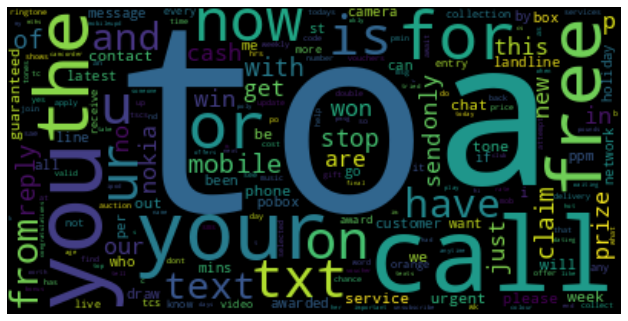

In [13]:
wordFrequency = wordFrequency.sort_values(by=["Spam"], ascending=False)
spamDict = {}

for x, y, z in wordFrequency.values:
    spamDict[x] = y
    
wordCloud = WordCloud().generate_from_frequencies(frequencies = spamDict)
plt.figure(figsize=[11,8])
plt.imshow(wordCloud, interpolation="bilinear")
plt.axis("off")
plt.show()

### Step 6
Create A New DataFrame Called wordProbability That Contains The Probability Of Each Word Being Found In A Spam Or ¬Spam Message. If A Word Was Not Found In A Spam Or ¬Spam Message, It Will Cause Problems Later As It Will Result In A Probability Of 0. Therefore, Use A Pseudocount K And Estimate The Probability Of Seeing The Word.

$`P(E|S)`$ = (Number Of Spams Containing The Word + K) / (Total Number Of Spam Messages + 2K)  
$`P(E|¬S)`$ = (Number Of ¬Spams Containing The Word + K) / (Total Number Of ¬Spam Messages + 2K) 

In [15]:
K = 0.65
wordProbability = pd.DataFrame(columns=['Word', 'P(E|S)','P(E|¬S)'])
totalNumberOfHamMessages = trainData['Category'].value_counts()[0]
totalNumberOfSpamMessages = trainData['Category'].value_counts()[1]

for x in wordFrequency["Word"]:
    
    Word = wordFrequency.loc[wordFrequency.Word == x, ['Spam', '¬Spam']]
    probabilityEventGivenItsSpam = (Word["Spam"].values[0] + K)/(totalNumberOfSpamMessages + (2 * K))
    probabilityEventGivenItsNotSpam = (Word["¬Spam"].values[0] + K)/(totalNumberOfHamMessages + (2 * K))
    wordProbability.loc[len(wordProbability.index)] = [x, probabilityEventGivenItsSpam, probabilityEventGivenItsNotSpam]
    
wordProbability.head(5)

,Word,P(E|S),P(E|¬S)
0,to,0.901871,0.323683
1,a,0.480946,0.220195
2,call,0.451498,0.046236
3,you,0.377014,0.376398
4,your,0.337173,0.083969


### Step 7
Now That The Model Has Been Trained, It Is Time To Test The Model. Before We Use testData, Calculate The Spamliness Of Any Single Word. This Is Where The Bayes Formula Will Be Used. As We Have Already Calculated $P(E|S)$ And $P(E|¬S)$, We Can Extract These From The wordProbability DataFrame. We Need To Decide The Prior Values $P(S)$ And $P(¬S)$ Which You Can Experiment By Tweaking The Values.

$P(S|E)=\frac{P(E|S)P(S)}{P(E|S)P(S)+P(E|¬S)P(¬S)}$

$P(¬S|E)=\frac{P(E|¬S)P(¬S)}{P(E|¬S)P(¬S)+P(E|S)P(S)}$

In [18]:
probabilitySpam = 0.35
probabilityNotSpam = 0.65

Word = wordProbability.loc[wordProbability.Word == "free", ['Word', 'P(E|S)', 'P(E|¬S)']]
probabilitySGivenE = (Word["P(E|S)"] * probabilitySpam)/((Word["P(E|S)"] * probabilitySpam) + (Word["P(E|¬S)"] * probabilityNotSpam))
probabilityNotSGivenE = (Word["P(E|¬S)"] * probabilityNotSpam)/((Word["P(E|¬S)"] * probabilityNotSpam) + (Word["P(E|S)"] * probabilitySpam))

print("Word = " + str(Word['Word'].values))
print("P(E|S) = " + str(Word['P(E|S)'].values))
print("P(E|¬S) = " + str(Word['P(E|¬S)'].values))
print("P(S|E) = " + str(probabilitySGivenE.values))
print("P(¬S|E) = " + str(probabilityNotSGivenE.values))

Word = ['free']
P(E|S) = [0.2921358]
P(E|¬S) = [0.01155564]
P(S|E) = [0.93156654]
P(¬S|E) = [0.06843346]


### Step 8
To Calculate The Spamliness Of A Message, We Multiply The Probabilities. The Model Assumes The Words Appear As Independent Events Hence The Naive Bayes. In Reality, Words Are Not Independent Events, But The Model Still Performs Well. If There Is A Word In The Message That Is Not In The wordProbability DataFrame Then You Can't Get The Probability. Skip Any Words In The Message That Are Not In The wordProbability DataFrame. 

$P(S|x_1, x_2, \dots, x_n) \approx \frac{P(S)\prod_{i=1}^{n}P(x_i|S)}{P(S)\prod_{i=1}^{n}P(x_i|S) + P(¬S)\prod_{i=1}^{n}P(x_i|¬S)}$

If $P(S|x_1, x_2, \dots, x_n) > P(¬S|x_1, x_2, \dots, x_n)$ Then We Assume The Message As Spam Else We Assume It As ¬Spam

In [20]:
# Got 3 Messages From The Test Data Set To Test The Model On Several Words
testingMessages = ["money!!! you r a lucky winner ! 2 claim your prize text money ! b00b text rate box403 w1t1jy", "So do you have samus shoulders yet", "Is that what time you want me to come?"]

for x in testingMessages:
        
    resultSpam = 1
    resultNotSpam = 1
    probNotSpam = []
    probSpam = []
    splitList = x.split()
    
    print("Message:", x)
    
    for y in splitList:
        
        if y in wordProbability["Word"].values:
            Word = wordProbability.loc[wordProbability.Word == y, ['P(E|S)', 'P(E|¬S)']]
            probSpam.append(Word["P(E|S)"].values[0])
            probNotSpam.append(Word["P(E|¬S)"].values[0])
    
    for n in probSpam:
        resultSpam *= n
        
    for n in probNotSpam:
        resultNotSpam *= n

    # Calculating P(S|x1, x2, .. xn) And P(¬S|x1, x2, .. xn)
    finalSpam = (probabilitySpam * resultSpam) / (probabilitySpam * resultSpam + probabilityNotSpam * resultNotSpam)
    finalNotSpam = (probabilityNotSpam * resultNotSpam) / (probabilityNotSpam * resultNotSpam + probabilitySpam * resultSpam)

    if finalSpam > finalNotSpam:
        print("Probably A Spam Email\nProbability Spam:", finalSpam, "\nProbability ¬Spam:", finalNotSpam, "\n-------------------------")
    
    else:
        print("Probably Not A Spam Email\nProbability Spam:", finalSpam, "\nProbability ¬Spam:", finalNotSpam, "\n-------------------------")

Message: money!!! you r a lucky winner ! 2 claim your prize text money ! b00b text rate box403 w1t1jy
Probably A Spam Email
Probability Spam: 0.9999999999996373 
Probability ¬Spam: 3.6262487361409777e-13 
-------------------------
Message: So do you have samus shoulders yet
Probably A Spam Email
Probability Spam: 0.5714479517219238 
Probability ¬Spam: 0.42855204827807625 
-------------------------
Message: Is that what time you want me to come?
Probably Not A Spam Email
Probability Spam: 0.08229870960723225 
Probability ¬Spam: 0.9177012903927677 
-------------------------


### Step 9
Our Aim Is To Compare Two Probabilities $P(S|x_1, x_2, ..., x_n)$ And $P(¬S|x_1, x_2, ..., x_n)$. Since Both Probabilities Share A Common Denominator, It Doesn't Affect The Comparison. Also, Multiplying A Small Set Of Probabilities Could Result In Floating-Point Errors Where The Product Becomes Too Small To Be Represented Correctly. To Avoid This, We Can Take The Logarithm Of The Numerator And Compare Them To Determine The Type Of Email.

$\log(P(S|x_1,x_2,\dots,x_n))\propto \log\left(P(S)\cdot P(x_1|S)\cdot P(x_2|S) \dots P(x_n|S)\right)=
\log(P(S))+\log(P(x_1|S))+\log(P(x_2|S))+\dots+\log(P(x_n|S))$

In [24]:
# Got 3 Messages From The Test Data Set To Test The Model On Several Words
testingMessages = ["Welp apparently he retired", "Filthy stories and GIRLS waiting for you", "Call 09050001808 from land line. Claim M95. Valid12hrs only"]

for x in testingMessages:
    
    splitList = x.split()
    probSpam = []
    probNotSpam = []
    probablySpam = 1
    probablyNotSpam = 1
    
    print("Message:", x)
    
    for y in splitList:
        
        if y in wordProbability["Word"].values:
            Word = wordProbability.loc[wordProbability.Word == y, ['P(E|S)', 'P(E|¬S)']]
            probSpam.append(Word["P(E|S)"].values[0])
            probNotSpam.append(Word["P(E|¬S)"].values[0])
            
    for n in probSpam:
        probablySpam *= n
        
    for n in probNotSpam:
        probablyNotSpam *= n
        
    # Changed The Formula To Log Of The Numerator
    probablySpam = log(probabilitySpam * probablySpam)
    probablyNotSpam = log(probabilityNotSpam * probablyNotSpam)
    
    if probablySpam > probablyNotSpam:
        print("Probably A Spam Email\nProbability Spam:", probablySpam, "\nProbability ¬Spam:", probablyNotSpam, "\n-------------------------")
    
    else:
        print("Probably Not A Spam Email\nProbability Spam:", probablySpam, "\nProbability ¬Spam:", probablyNotSpam, "\n-------------------------")

Message: Welp apparently he retired
Probably Not A Spam Email
Probability Spam: -21.417257058976706 
Probability ¬Spam: -18.21008442071786 
-------------------------
Message: Filthy stories and GIRLS waiting for you
Probably A Spam Email
Probability Spam: -14.827113141438055 
Probability ¬Spam: -19.090470762613577 
-------------------------
Message: Call 09050001808 from land line. Claim M95. Valid12hrs only
Probably A Spam Email
Probability Spam: -9.034852887886151 
Probability ¬Spam: -16.228793051387854 
-------------------------


### Step 10
Now That We Have Tested The Model Using Simple Messages, Let’s Test The Model Using The Messages From testData. You Should Implement Counters That Displays How Your Model Has Performed And Calculate The Accuracy Of The Model.

In [29]:
matchSpam = 0
matchNotSpam = 0
thoughtNotSpamSpam = 0
thoughtSpamNotSpam = 0

for x in testData["Message"]:
    
    Word = testData.loc[testData.Message == x, ['Category']]
    category = Word['Category'].values[0].capitalize()
    resultSpam = 1
    resultNotSpam = 1
    probSpam = []
    probNotSpam = []
    splitList = x.split()
    
    for y in splitList:
        
        if y in wordProbability["Word"].values:
            Word = wordProbability.loc[wordProbability.Word == y, ['P(E|S)', 'P(E|¬S)']]
            probSpam.append(Word["P(E|S)"].values[0])
            probNotSpam.append(Word["P(E|¬S)"].values[0])
            
    for n in probSpam:
        resultSpam *= n
        
    for n in probNotSpam:
        resultNotSpam *= n
        
    resultSpam = log(probabilitySpam * resultSpam)
    resultNotSpam = log(probabilityNotSpam * resultNotSpam)
    
    if resultSpam > resultNotSpam:
        
        if(category == "Spam"):
            matchSpam += 1
            
        else:
            thoughtNotSpamSpam += 1
            
    else:
        
        if(category == "Ham"):
            matchNotSpam += 1

        else:
            thoughtSpamNotSpam += 1
            
print("Matched Spam:", matchSpam)
print("Matched ¬Spam:", matchNotSpam)
print("Thought ¬Spam Is Spam:", thoughtNotSpamSpam)
print("Thought Spam Is ¬Spam:", thoughtSpamNotSpam)
print("Accuracy: " + str(round(((matchSpam + matchNotSpam)/len(testData["Message"]))*100, 2)) + "%")

Matched Spam: 166
Matched ¬Spam: 1038
Thought ¬Spam Is Spam: 184
Thought Spam Is ¬Spam: 5
Accuracy: 86.43%


### Evaluation
Using Naïve Bayes I Was Able To Implement An Email Spam Filter By Teaching The Model The Type Of Words That Appear In Spam Messages And Caclculating Their Probabilities. The Model Produced Is Highly Accurate With A Success Rate Of 86.43% Which Means The Model Is Able To Predict To A Great Extent Whether Or Not The Email Is Spam. However, To Increase This Accuracy Further, I Could've Increased The Dataset Size For Training The Model So That It Is Fed With More Data Thus Predicting To A Higher Degree Of Accuracy As It Would Cover A Greater Range Of Emails. Also, I Could Find A Closer To Reality Prior Value (P(S) and P(¬S)) So That The Model Will Perform Closer To What Is Expected In Real Terms Hence Feeding It With Real Emails Will Produce A More Accurate Result.